In [1]:
from legal_backend.r_to_py.r_to_py import init_R
from legal_backend.bartCause.bart_cause import BARTCause
from legal_backend.pip_utils import prepare_train_data, rmse, nrmse, r_square, coverage_rate, kfold_indices, prepare_permute_data, statistic

import pandas as pd
import numpy as np
from sklearn import preprocessing

from scipy.stats import permutation_test
from matplotlib import pyplot as plt
from scipy import stats
from collections import Counter



In [2]:
init_R()

### Infer Law Effect

In [3]:
#load csv files and load possible laws
df = pd.read_csv('data/pdmp_all.csv')

In [4]:
df.rename(columns={'death-rate-2013-2016':'delta_death_rate'}, inplace=True)
df['Urbanicity'] = df['Urbanicity'].map({'Urban':1, 'Rural':0})
df.columns

Index(['Percent-of-Population-Under-15-(2013-2017)',
       'Percent-of-Population-Aged-15-to-64-(2013-2017)',
       'Percent-of-Population-65+-(2013-2017)',
       'Percent-of-Population-White-(non-Hispanic)-(2013-2017)',
       'Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)',
       'Percent-of-Population-Hispanic-or-Latino-(2013-2017)',
       'Percent-of-Population-Asian-(non-Hispanic)-(2013-2017)',
       'Percent-of-Population-Native-American/Alaska-Native-(non-Hispanic)-(2013-2017)',
       'Percent-of-Population-Native-Hawaiian/Pacific-Islander-(2013-2017)',
       'Percent-of-Population-Aged-25+-who-Have-at-Least-a-High-School-Diploma-(2013-2017)',
       'Percent-of-Population-Aged-25+-who-Have-a-Bachelor's-Degree-or-More-(2013-2017)',
       'Poverty-Rate-(2013-2017)', 'Median-Household-Income-(2013-2017)',
       'Unemployment-Rate-(2013-2017)',
       'Percent-of-Residents-with-a-Disability-(Aged-18-64)-(2013-2017)',
       'Percent-of-Popualtion-Employed-in-Mini

###  Patterns

In [5]:
df_sub = df.copy(deep=True)
"df_sub['Urbanicity']==1"
"df_sub['Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017)']<0.009"
"df_sub['Percent-of-Population-Native-Hawaiian/Pacific-Islander-(2013-2017)']<0.001"
"df_sub['Number-of-Mental-Health-Facilities-(As-of-March-2023)']>2"
"df_sub['Economic-Risk-Score']==2"
"df_sub['Percent-of-Population-Native-American/Alaska-Native-(non-Hispanic)-(2013-2017)']<0.002"
"df_sub['Unemployment-Rate-(2013-2017)']<0.122"
"df_sub['Unemployment-Rate-(2013-2017)']>0.048"
"df_sub['MDsPerCapita']>9.17"

"df_sub['MDsPerCapita']>9.17"

In [6]:
conds = []
# conds.append("df_sub['Percent-of-Population-Native-American/Alaska-Native-(non-Hispanic)-(2013-2017)']<0.002")
# conds.append("df_sub['Unemployment-Rate-(2013-2017)']<0.122")
# conds.append("df_sub['Unemployment-Rate-(2013-2017)']>0.048")
# conds.append("df_sub['MDsPerCapita']>9.17")
for cond in conds:
    df_sub = df_sub.loc[eval(cond)].reset_index(drop=True)
# df_sub = df_sub[df_sub['Percent-of-Population-Native-Hawaiian/Pacific-Islander-(2013-2017)']<0.001].reset_index(drop=True)
# df_sub = df_sub[df_sub['Urbanicity']==1].reset_index(drop=True)
law = 'must-access'

In [7]:
print(law)
print(df_sub.shape[0])
df_sub.head()

must-access
3137


,Percent-of-Population-Under-15-(2013-2017),Percent-of-Population-Aged-15-to-64-(2013-2017),Percent-of-Population-65+-(2013-2017),Percent-of-Population-White-(non-Hispanic)-(2013-2017),Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017),Percent-of-Population-Hispanic-or-Latino-(2013-2017),Percent-of-Population-Asian-(non-Hispanic)-(2013-2017),Percent-of-Population-Native-American/Alaska-Native-(non-Hispanic)-(2013-2017),Percent-of-Population-Native-Hawaiian/Pacific-Islander-(2013-2017),Percent-of-Population-Aged-25+-who-Have-at-Least-a-High-School-Diploma-(2013-2017),...,share-dispecheck,dispenser-freq,share-stateagen,share-insurance,state-share,share-provision_Receiving state must allow reciprocity with this state,share-provision_Must have bilateral memorandum of understanding or data sharing agreement,share-provision_Only if other state has PDMP laws consistent with or similar to this state,share-provision_Physically bordering states only or higher priority,share-provision_None of the above restrictions
0,0.2040,0.6562,0.1398,0.7568,0.1837,0.0257,0.0081,0.0041,0.0001,0.8758,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.1830,0.6298,0.1871,0.8318,0.0923,0.0437,0.0066,0.0062,0.0000,0.9003,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.1794,0.6553,0.1653,0.4589,0.4789,0.0431,0.0044,0.0017,0.0000,0.7376,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.1702,0.6809,0.1489,0.7477,0.2121,0.0222,0.0006,0.0036,0.0000,0.8070,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.1942,0.6339,0.1719,0.8766,0.0156,0.0873,0.0016,0.0030,0.0000,0.8003,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [8]:
print(Counter(df_sub[law]))
num_instances = list(Counter(df_sub[law]).values())
imbalance_ratio = min(num_instances) / max(num_instances)
print("Imbalanced Data Detected! Imbalnce Ratio:", imbalance_ratio) if (imbalance_ratio < 0.1) else None

Counter({0.0: 2162, 1.0: 975})


In [9]:
X_train_scaled, y_train, Z_train, X_test_scaled, y_test, Z_test = prepare_train_data(df_sub, law)

In [10]:
bart_eval = BARTCause()
bart_eval.fit(X_train_scaled, y_train, Z_train, n_samples=1000,  n_burn=200,  n_chains=5)

In [11]:
# evaluate BART fit on response surface
newData = np.concatenate((X_test_scaled, Z_test), axis=1)

y_test_predicted_, y_test_predicted_lb, y_test_predicted_ub = bart_eval.predict(newData, infer_type="mu")

# y_test_predicted_ = bart_eval.predict(newData, infer_type="mu")
y_test_predicted = y_test_predicted_[:,np.newaxis]
y_test_predicted_lb = y_test_predicted_lb[:,np.newaxis]
y_test_predicted_ub = y_test_predicted_ub[:,np.newaxis]

In [12]:
print("BART RMS:", rmse(y_test,y_test_predicted),"\n", "Baseline RMS:", rmse(y_test,y_test.mean()))
print("r square:", r_square(y_test,y_test_predicted), "\n", "nrmse:", nrmse(y_test, y_test_predicted, 'range'))
print("coverage rate:", coverage_rate(y_test, y_test_predicted_lb, y_test_predicted_ub))

BART RMS: 24.59015788927907 
 Baseline RMS: 30.39340301528534
r square: 0.34541812332979593 
 nrmse: 0.08687942155500687
coverage rate: 0.5955414012738853


#### K-fold Cross Validation

In [13]:
fold_indices = kfold_indices(df_sub, 5)

In [14]:
def cross_validation_test(df, law, fold_indices):
    bartCause = BARTCause()
    
    X_df = df.iloc[:, :27].to_numpy()
    M = X_df.shape[1] 

    y = df[['delta_death_rate']].to_numpy()
    Z_law = df[[law]].to_numpy()
    # numerical columns
    num_cols = [c for c in range(M) if len(np.unique(X_df[:, c])) > 2] 

    scores = []

    for fold, (train_indices, test_indices) in enumerate(fold_indices):
        print("fold:",fold)
        X_train, y_train, Z_train = X_df[train_indices,:], y[train_indices,:], Z_law[train_indices,:]
        X_test, y_test, Z_test = X_df[test_indices,:], y[test_indices,:], Z_law[test_indices,:]

        # standardize data
        scaler_ = preprocessing.StandardScaler().fit(X_train[:,num_cols])
        X_train_scaled = np.copy(X_train)
        X_train_scaled[:,num_cols] = scaler_.transform(X_train[:,num_cols])

        X_test_scaled = np.copy(X_test)
        X_test_scaled[:,num_cols] = scaler_.transform(X_test[:,num_cols])
        
        # Train the model on the training data
        bartCause.fit(X_train_scaled, y_train, Z_train, n_samples=1000,  n_burn=200,  n_chains=5)

        # Make predictions on the test data
        test_data = np.concatenate((X_test_scaled, Z_test), axis=1)
        y_test_pred_, _, _ = bartCause.predict(test_data, infer_type="mu")
        y_test_pred = y_test_pred_[:,np.newaxis]
        
        # Calculate the accuracy score for this fold
        fold_score = nrmse(y_test, y_test_pred, 'range')
        
        # Append the fold score to the list of scores
        scores.append(fold_score)

    # Calculate the mean accuracy across all folds
    mean_score = np.mean(scores)

    return scores, mean_score

In [15]:
# scores, mean_score = cross_validation_test(df_sub, law, fold_indices)
# print("K-Fold Cross-Validation Scores:", scores)
# print("Mean Score:", mean_score)

#### Permutation Test

In [16]:
bartCause = BARTCause()
X_scaled, y, Z_law = prepare_permute_data(df_sub, law)
bartCause.fit(X_scaled, y, Z_law, n_samples=1000,  n_burn=200,  n_chains=5)

In [17]:
# evaluate BART fit on response surface
newData = np.concatenate((X_scaled, Z_law), axis=1)

predicted_Z1, _, _ = bartCause.predict(newData, infer_type="mu.1")
predicted_Z0, _, _ = bartCause.predict(newData, infer_type="mu.0")
# predicted_Z1 = predicted_Z1_[:,np.newaxis]
# predicted_Z0 = predicted_Z0_[:,np.newaxis]
mean_law0 = predicted_Z0.mean()
mean_law1 = predicted_Z1.mean()
avg_ite = (predicted_Z1 - predicted_Z0).mean()
std_ite = (predicted_Z1 - predicted_Z0).std()
print("Avg ITE:", avg_ite,"Stdev ITE:",std_ite)

Avg ITE: 7.853003598707559 Stdev ITE: 5.349569405095129


#### Permutation test

In [18]:
alternative_str = 'less' if avg_ite > 0 else 'greater'

In [19]:
res_permute = permutation_test((predicted_Z0, predicted_Z1), statistic, alternative=alternative_str)
res_permute

PermutationTestResult(statistic=-7.853003598707559, pvalue=0.0001, null_distribution=array([ 0.03524578,  0.37537795,  0.06556495, ..., -0.88534382,
        0.08512776, -0.02924135]))

#### Paired Samples t-Test (Dependent Samples t-Test)

In [20]:
res_ttest = stats.ttest_rel(predicted_Z0, predicted_Z1, alternative=alternative_str)
res_ttest

TtestResult(statistic=-82.20628021178148, pvalue=0.0, df=3136)

#### Mann-Whitney U Test / Wilcoxon Rank-Sum Test (No normal distribution assumption)

In [21]:
res_mannwhitneyu = stats.mannwhitneyu(predicted_Z0, predicted_Z1, alternative=alternative_str)
res_mannwhitneyu

MannwhitneyuResult(statistic=3249669.0, pvalue=2.7918585562825594e-120)

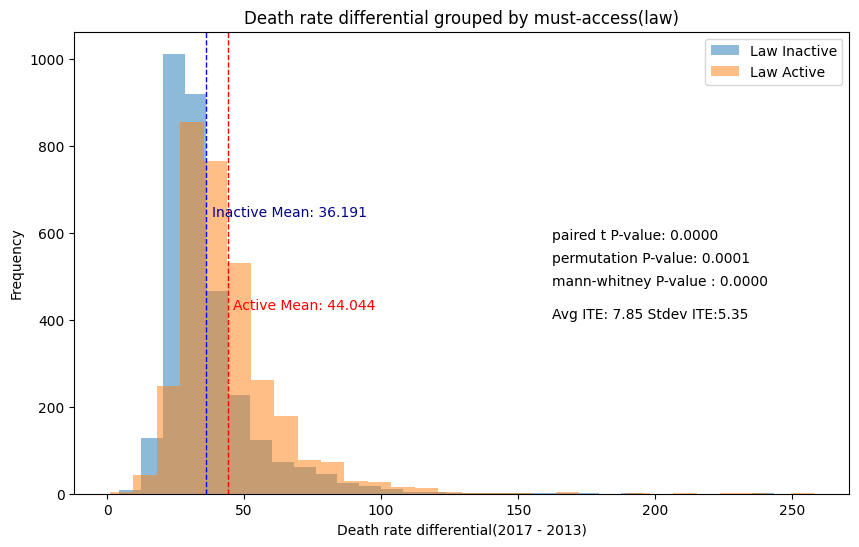

In [23]:

plt.figure(figsize=(10, 6))
plt.hist(predicted_Z0, bins=30, alpha=0.5, label='Law Inactive')
plt.hist(predicted_Z1, bins=30, alpha=0.5, label='Law Active')

plt.axvline(mean_law0, color='blue', linestyle='dashed', linewidth=1)
plt.text(mean_law0 + 2, plt.ylim()[1] * 0.6, f'Inactive Mean: {mean_law0:.3f}', color='darkblue')
plt.axvline(mean_law1, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_law1 + 2, plt.ylim()[1] * 0.4, f'Active Mean: {mean_law1:.3f}', color='red')

plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.45, f'mann-whitney P-value : {res_mannwhitneyu.pvalue:.4f}', color='black')
plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.5, f'permutation P-value: {res_permute.pvalue:.4f}', color='black')
plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.55, f'paired t P-value: {res_ttest.pvalue:.4f}', color='black')
plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.38, f'Avg ITE: {avg_ite:.2f} Stdev ITE:{std_ite:.2f}', color='black', fontsize=10)

if len(conds) > 0:
    for i,cond in enumerate(conds):
        cond_text = cond[6:] 
        plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * -0.15 -0.6 * i, cond_text, color='black')


plt.xlabel('Death rate differential(2017 - 2013)')
plt.ylabel('Frequency')
plt.title('Death rate differential grouped by '+ law+'(law)')
plt.legend()
# plt.savefig("demo_res/law_"+law+".png")
plt.show()